In [1]:
import argparse
import json
import os
import pdb
import pickle
import random
import time
from collections import OrderedDict
from Process_Data.Datasets.LmdbDataset import Hdf5DelectDataset
import Process_Data.constants as c
import h5py

import numpy as np
import torch
import torch._utils
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from kaldi_io import read_mat
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

from Define_Model.SoftmaxLoss import AngleLinear, AdditiveMarginLinear
# from Define_Model.model import PairwiseDistance
from Process_Data.Datasets.KaldiDataset import ScriptTrainDataset, \
    ScriptTestDataset, ScriptValidDataset
from Process_Data.audio_processing import ConcateOrgInput, mvnormal, ConcateVarInput
from TrainAndTest.common_func import create_model, load_model_args, args_model, args_parse

In [2]:
import matplotlib.pyplot as plt
from python_speech_features import hz2mel, mel2hz

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
seed = 123456
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.multiprocessing.set_sharing_strategy('file_system')

In [4]:
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch/'

In [6]:
transform = transforms.Compose([
    ConcateOrgInput(remove_vad=False),
])

In [8]:
select_input_dir = root_path + 'Data/gradient/ThinResNet34_ser07/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/vox2_dev4'
train_dir = Hdf5DelectDataset(select_dir=select_input_dir, 
                              transform=transform)

kwargs = {'num_workers': 8, 'pin_memory': False} 
train_loader = DataLoader(train_dir, batch_size=1, shuffle=False, **kwargs)

model_dir = 'ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_chn32_wd5e5_varesmix8/arcsoft_sgd_rop/vox2/wave_fb80_dist_frl/123456' #/model.2023.06.07.yaml
check_path = root_path + 'Data/checkpoint/' + model_dir
check_yaml = check_path + '/model.2023.06.07.yaml'

Examples uids:  [['id00012-21Uxsk56VDQ-00001', 0], ['id00012-21Uxsk56VDQ-00002', 0]]


In [ ]:
select_input_dir = root_path + ' Data/checkpoint/ThinResNet18/Mean_batch256_basic_downk3_avg10_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/aishell2/wave_fb80_dist2'
train_dir = Hdf5DelectDataset(select_dir=select_input_dir, 
                              transform=transform)

kwargs = {'num_workers': 8, 'pin_memory': False} 
train_loader = DataLoader(train_dir, batch_size=1, shuffle=False, **kwargs)

In [10]:
model_dir = 'ThinResNet18/Mean_batch256_basic_downk3_avg10_SAP2_em256_dp01_alpha0_none1_wde4_esmix2/arcsoft_sgd_rop/aishell2/wave_fb80_dist2_frl/123456' #/model.2023.06.07.yaml
check_path = root_path + 'Data/checkpoint/' + model_dir
check_yaml = check_path + '/model.2023.06.06.yaml'

In [12]:
model_kwargs = load_model_args(check_yaml)
model = model_kwargs['embedding_model']
model.classifier = model_kwargs['classifier']

resume_path = check_path + '/checkpoint_{}.pth'

ep = 16 # Load model from Checkpoint file
if os.path.isfile(resume_path.format(ep)):
    
    checkpoint = torch.load(resume_path.format(ep))
    checkpoint_state_dict = checkpoint['state_dict']
    if isinstance(checkpoint_state_dict, tuple):
        checkpoint_state_dict = checkpoint_state_dict[0]

    filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
    if list(filtered.keys())[0].startswith('module'):
        new_state_dict = OrderedDict()
        for k, v in filtered.items():
            name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
            new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。

        model.load_state_dict(new_state_dict)
    else:
        model_dict = model.state_dict()
        model_dict.update(filtered)
        model.load_state_dict(model_dict)

In [13]:
sig = torch.nn.Sigmoid()

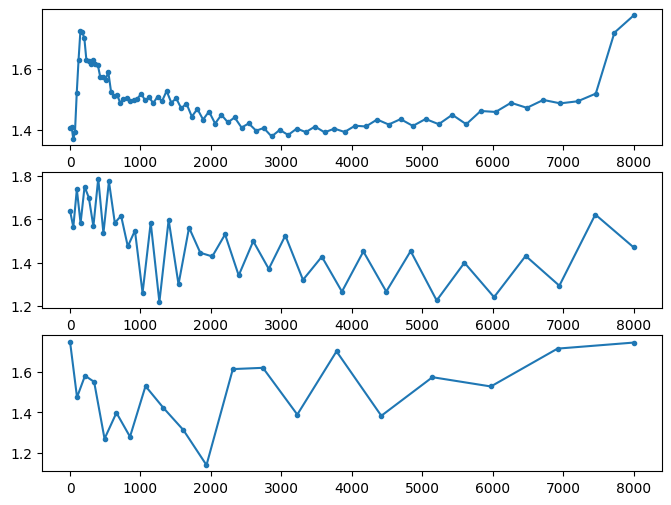

In [15]:
plt.figure(figsize=(8, 6))

plt.subplot(3,1,1)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)
y = model.input_mask[2].weight.data.detach().cpu()
y = sig(y)+1
plt.plot(x, y.numpy().squeeze(), marker='.')

plt.subplot(3,1,2)
x = np.linspace(0, hz2mel(8000), 40)
x = mel2hz(x)
y = model.layer1[3].weight.data.detach().cpu()
y = sig(y)+1
plt.plot(x, y.numpy().squeeze(), marker='.')

plt.subplot(3,1,3)
x = np.linspace(0, hz2mel(8000), 20)
x = mel2hz(x)
y = model.layer2[4].weight.data.detach().cpu()
y = sig(y)+1
plt.plot(x, y.numpy().squeeze(), marker='.')

In [26]:
model.input_mask[2].weight.data.detach().cpu().numpy().squeeze()

array([-0.372091  , -0.36088368, -0.5256869 , -0.43017116,  0.08170482,
        0.5241241 ,  0.9608121 ,  0.9319133 ,  0.83777535,  0.5171224 ,
        0.50357014,  0.46190435,  0.52594495,  0.46803102,  0.45654735,
        0.2903008 ,  0.29916856,  0.2575614 ,  0.36135682,  0.09370901,
        0.04514276,  0.06154818, -0.04638653,  0.00517583,  0.0219956 ,
       -0.01723054, -0.00791477,  0.00892688,  0.07518334, -0.01262245,
        0.0261607 , -0.04910694,  0.03719741, -0.02339946,  0.1095757 ,
       -0.04271674,  0.01353554, -0.11595145, -0.05349117, -0.22422145,
       -0.12427017, -0.26336432, -0.15769258, -0.316127  , -0.20123214,
       -0.3009071 , -0.234763  , -0.37025055, -0.31438896, -0.41212988,
       -0.37559047, -0.49121708, -0.40091485, -0.47059098, -0.38277104,
       -0.43149462, -0.35610455, -0.43415663, -0.3843138 , -0.42925218,
       -0.34502178, -0.3553272 , -0.26267263, -0.32894567, -0.2575898 ,
       -0.34775907, -0.25566468, -0.32471707, -0.20031643, -0.32

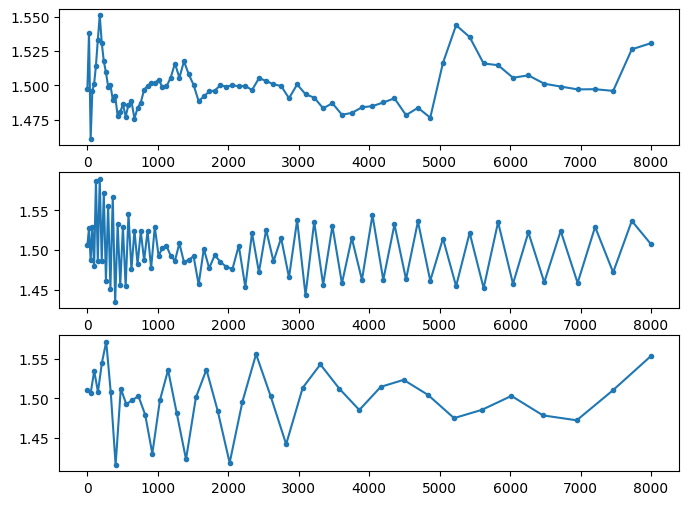

In [17]:
plt.figure(figsize=(8, 6))

plt.subplot(3,1,1)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)
y = model.input_mask[2].weight.data.detach().cpu()
y = sig(y)+1
plt.plot(x, y.numpy().squeeze(), marker='.')

plt.subplot(3,1,2)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)
y = model.layer1[2].weight.data.detach().cpu()
y = sig(y)+1
plt.plot(x, y.numpy().squeeze(), marker='.')

plt.subplot(3,1,3)
x = np.linspace(0, hz2mel(8000), 40)
x = mel2hz(x)
y = model.layer2[2].weight.data.detach().cpu()
y = sig(y)+1
plt.plot(x, y.numpy().squeeze(), marker='.')

plt.savefig('imgs/aishell2_trained_frl.png', bbox_inches='tight')

In [16]:
model_dir = 'ThinResNet34/Mean_batch128_k7_seblock_downk1_avg1_SAP2_em256_dp01_alpha0_none1_chn32_wd5e5_varesmix8/arcsoft_sgd_rop/vox2/wave_fb80_dist_frl2/123456' #/model.2023.06.07.yaml
check_path = '../../Data/checkpoint/' + model_dir
check_yaml = check_path + '/model.2023.06.12.yaml'

In [17]:
model_kwargs = load_model_args(check_yaml)
model = model_kwargs['embedding_model']
model.classifier = model_kwargs['classifier']
resume_path = check_path + '/checkpoint_{}.pth'

ep = 31 # Load model from Checkpoint file
if os.path.isfile(resume_path.format(ep)):
    
    checkpoint = torch.load(resume_path.format(ep))
    checkpoint_state_dict = checkpoint['state_dict']
    if isinstance(checkpoint_state_dict, tuple):
        checkpoint_state_dict = checkpoint_state_dict[0]

    filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
    if list(filtered.keys())[0].startswith('module'):
        new_state_dict = OrderedDict()
        for k, v in filtered.items():
            name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
            new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。

        model.load_state_dict(new_state_dict)
    else:
        model_dict = model.state_dict()
        model_dict.update(filtered)
        model.load_state_dict(model_dict)

In [36]:
avg = torch.nn.AvgPool1d(kernel_size=3, stride=2, padding=1)

In [48]:
x = np.linspace(0, hz2mel(8000), 80)
thex = torch.tensor(mel2hz(x)).unsqueeze(0).unsqueeze(0)

the2x = avg(thex)
the4x = avg(the2x)

In [49]:
print(the2x.shape, the4x.shape)

torch.Size([1, 1, 40]) torch.Size([1, 1, 20])


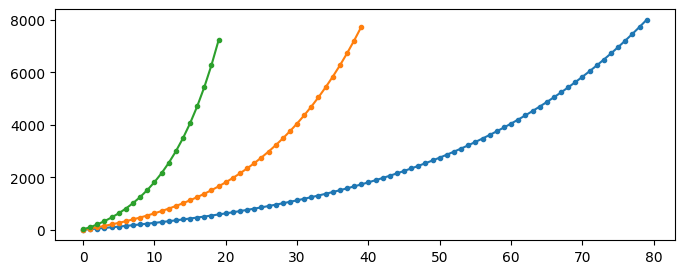

In [51]:
plt.figure(figsize=(8, 3))
plt.plot(thex.squeeze(),  marker='.')
plt.plot(the2x.squeeze(), marker='.')
plt.plot(the4x.squeeze(), marker='.')

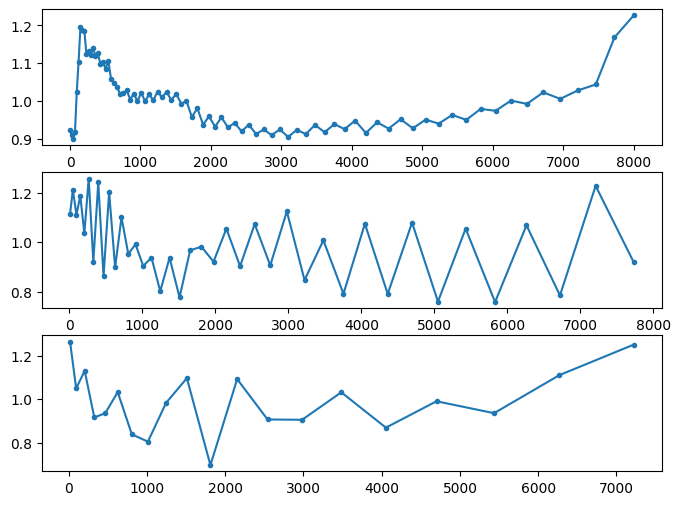

In [33]:
plt.figure(figsize=(8, 6))

plt.subplot(3,1,1)
x = np.linspace(0, hz2mel(8000), 80)
x = mel2hz(x)
y = model.input_mask[2].weight.data.detach().cpu()
y = sig(y)+0.5
plt.plot(x, y.numpy().squeeze(), marker='.')

plt.subplot(3,1,2)
x = np.linspace(0, hz2mel(8000), 40)
x = mel2hz(x)
y = model.layer1[3].weight.data.detach().cpu()
y = sig(y)+0.5
plt.plot(the2x.squeeze(), y.numpy().squeeze(), marker='.')

plt.subplot(3,1,3)
x = np.linspace(0, hz2mel(8000), 20)
x = mel2hz(x)
y = model.layer2[4].weight.data.detach().cpu()
y = sig(y)+0.5
plt.plot(the4x.squeeze(), y.numpy().squeeze(), marker='.')

In [44]:
ones = torch.ones(1,1,80)

y = model.input_mask[2].weight.data.detach().cpu()
y = sig(y)+0.5
y1 = ones * y

y1_2 = avg(y1.squeeze(0))
y = model.layer1[3].weight.data.detach().cpu()
y = sig(y)+0.5
y1_2 = y1_2.unsqueeze(0) * y

y1_4 = avg(y1_2.squeeze(0))
y = model.layer2[4].weight.data.detach().cpu()
y = sig(y)+0.5
y1_4 = y1_4.unsqueeze(0) * y

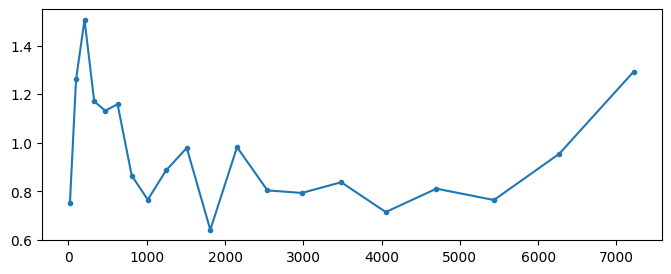

In [46]:
plt.figure(figsize=(8, 3))
plt.plot(the4x.squeeze(), y1_4.numpy().squeeze(), marker='.')